<a href="https://colab.research.google.com/github/haylee94/Section1_project/blob/main/Part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 확인하세요!

### 제출 전에 모든 코드가 순차적으로 잘 작동하는지 확인하세요. 
- **커널을 다시 시작**한 다음(메뉴바에서 Kernel $\rightarrow$ Restart 선택) **모든 셀을 실행**해 보세요(메뉴바에서 Cell $\rightarrow$ Run All 선택).

### 지정 셀의 지정 영역에서만 코드를 작성했는지 확인하세요.
- `YOUR CODE HERE`이 적혀 있는 셀에 대한 코드만 채점에 반영됩니다.
- `YOUR CODE HERE` ~ `YOUR CODE ENDS HERE` 사이에 본인의 코드를 작성하세요.
- 지정 셀 이외에 본인이 코드 실행 결과를 확인하기 위한 용도로 셀을 추가해도 됩니다.
    - **제출 시 지정 셀에서는 정답 이외에 결과 확인을 위한 코드 등은 제거하고 제출해 주세요!**
    - **기존 셀을 삭제하지 마세요! 채점에 불이익이 있을 수 있습니다.**

### 제출 방법
- 시간 내에 문제를 풀고, 본인의 github repo에 push 하세요.
    - **디렉토리 구조가 변하면 안 됩니다.** `codestates/ds-sc2xx`와 디렉토리 구조가 동일해야 합니다. 답안 파일의 이름을 변경하지 않았는지, 기존에 없던 폴더가 추가되지 않았는지 등을 확인하세요.
    - **코드스테이츠 가입 시 연동한 github 계정을 사용해야 합니다.**
    - **branch를 변경하여 작업하지 마세요.**
        - `master` branch에의 제출 사항에 대해서만 평가합니다.
        - 본인의 github repo `master` branch에 제출이 잘 되어 있는지 확인하세요.

---

# SC21x
 
## 선형모델 (Linear Models)

In [1]:
import sys
import warnings

if "google.colab" in sys.modules:
    ## Colab에서 실행하는 경우 필요한 라이브러리를 미리 설치합니다.
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*
    # !pip install plotly==4.*

warnings.filterwarnings("ignore")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Part 1 - 분류 (Classification): 헌혈 여부 예측하기 🚑
Part 1에선 대만의 이동식 헌혈 차량 헌혈자들의 정보를 담은 데이터셋을 다룹니다. 대만의 수혈 서비스 센터 (The Blood Transfusion Service Center)는 이동식 차량으로 대학교들을 돌면서 헌혈 행사를 진행, 수혈을 위한 혈액을 기부 받습니다.

Part 1의 목표는 각 헌혈자의 정보를 활용해서 **헌혈자가 2007년 3월에 헌혈을 했는지 여부**를 예측하는 것입니다. 

헌혈 여부 및 공급 요구를 추적하고 예측하는 좋은 데이터 기반 시스템은 공급망 전체를 개선하여 더 많은 환자가 필요한 수혈을 받도록 할 수 있습니다.

In [2]:
# 분석에 필요한 라이브러리 및 데이터셋을 불러옵니다
import pandas as pd

donors = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/blood-transfusion/transfusion.data"
)
assert donors.shape == (748, 5)  # 데이터셋이 잘 로드 됐는지 확인하기 위해서 assert를 사용해 검증합니다.

# 칼럼의 이름을 이해하기 쉽도록 변경합니다.
donors = donors.rename(
    columns={
        "Recency (months)": "months_since_last_donation",
        "Frequency (times)": "number_of_donations",
        "Monetary (c.c. blood)": "total_volume_donated",
        "Time (months)": "months_since_first_donation",
        "whether he/she donated blood in March 2007": "made_donation_in_march_2007",
    }
)

In [3]:
pd.set_option('display.max_columns', None) # Pandas를 활용해 시각적 탐색(열전체)
pd.set_option('display.max_rows', None) # Pandas를 활용해 시각적 탐색(행전체)

In [4]:
donors.head()

,months_since_last_donation,number_of_donations,total_volume_donated,months_since_first_donation,made_donation_in_march_2007
0,2,50,12500,98,1
1,0,13,3250,28,1
2,1,16,4000,35,1
3,2,20,5000,45,1
4,1,24,6000,77,0


## 칼럼 설명:
- **months_since_last_donation**: 마지막으로 헌혈을 한 후에 지난 개월수
- **number_of_donations**: 헌혈 횟수
- **total_volume_donated**: 기부한 혈액 총량
- **months_since_first_donation**: 첫 헌혈을 한 후에 지난 개월수
- **made_donation_in_march_2007**: 2007년 헌혈을 했는지 여부 (target)

데이터를 본다면 약 3/4에 해당하는 과반수가 2007년 3월에 헌혈을 하지 않았다는 것을 알 수 있습니다.  
아래는 Baseline 모델의 정확도 점수 (accuracy score)를 나타낸 것입니다.

In [5]:
donors["made_donation_in_march_2007"].value_counts(normalize=True)

0    0.762032
1    0.237968
Name: made_donation_in_march_2007, dtype: float64

In [6]:
from sklearn.metrics import accuracy_score, f1_score

major = donors["made_donation_in_march_2007"].mode()[0]
baseline = [major] * len(donors)

y_true = donors["made_donation_in_march_2007"]

acc_score = accuracy_score(y_true, baseline).round(3)
f1score = f1_score(y_true, baseline, labels=[0,1], pos_label=1)
print(f'baseline의 정확도 : {acc_score}')
print(f'baseline의 f1 score : {f1score}')

baseline의 정확도 : 0.762
baseline의 f1 score : 0.0


## 1.1 데이터를 feature (X), label(y)로 분할하고 데이터를 train/test 셋으로 나누는 `divide_donors_data_and_split`함수를 작성하세요 (scikit-learn 활용).
- donors dataframe을 독립변수 dataframe과 종속변수 series로 나눠 주세요
  - 종속변수 외 나머지 변수는 모두 독립변수로 간주하세요
- sklearn train_test_split 함수를 사용해 Train / Test 비율을 3:1로 나눠 주세요. random_state는 42를 사용하세요.

In [7]:
from sklearn.model_selection import train_test_split

# train, test 데이터 분할
train, test = train_test_split(donors, test_size=0.25, random_state=42)

In [8]:
target = 'made_donation_in_march_2007'
features = ['months_since_last_donation', 'number_of_donations', 'total_volume_donated', 'months_since_first_donation']

# X와 y를 나누는 함수
def x_y_split(donors) :
    X = donors[features]
    y = donors[target]
    return X, y

In [9]:
# X와 y로 나누기
X_train, y_train = x_y_split(train)
X_test, y_test = x_y_split(test)

In [10]:
# 데이터shape
print(f'X_train: {X_train.shape}, y_train: {y_train.shape}')
print(f'X_test: {X_test.shape}, y_test: {y_test.shape}')

X_train: (561, 4), y_train: (561,)
X_test: (187, 4), y_test: (187,)


In [11]:
from sklearn.model_selection import train_test_split


def divide_donors_data_and_split(donors):
    target = "made_donation_in_march_2007"
    X = None
    y = None
    
    # YOUR CODE HERE
    
    train, test = train_test_split(donors, test_size=0.25, random_state=42)

    target = 'made_donation_in_march_2007'
    features = ['months_since_last_donation', 'number_of_donations', 'total_volume_donated', 'months_since_first_donation']

    X = donors[features]
    y = donors[target]

    X_train, y_train = x_y_split(train)
    X_test, y_test = x_y_split(test)

    
    # YOUR CODE ENDS HERE

    return X_train, X_test, y_train, y_test

In [12]:
X_train, X_test, y_train, y_test = divide_donors_data_and_split(donors)

In [13]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(561, 4) (187, 4) (561,) (187,)


## 1.2 Logistic regression 모델을 학습 (fit)하고 학습된 모델과 test accuracy, f1 score를 반환하는 `fit_logistic_regression`함수를 작성하세요.

In [25]:
from sklearn.linear_model import LogisticRegression
logistic = LogisticRegression(class_weight='balanced')
logistic.fit(X_train, y_train)

print('logistic train accuracy', logistic.score(X_train, y_train).round(2))

logistic train accuracy 0.66


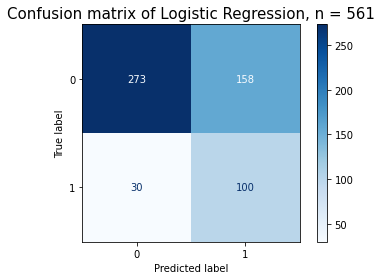

In [26]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
pcm = plot_confusion_matrix(logistic, X_train, y_train,
                            cmap=plt.cm.Blues,
                            ax=ax)
plt.title(f'Confusion matrix of Logistic Regression, n = {len(y_train)}', fontsize=15)
plt.show()

In [20]:
cm = pcm.confusion_matrix
cm

array([[273, 158],
       [ 30, 100]])

In [21]:
# rows = True label, cols = PredictedLabel
TP = cm[1][1]
FP = cm[0][1]
FN = cm[1][0]
TN = cm[0][0]

accuracy = (TP + TN) / cm.sum()
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = 2*precision*recall/(precision+recall)

print(f'accuracy of logistic regression is {accuracy.round(2)}')
print(f'precision of logistic regression is {precision.round(2)}')
print(f'recall of logistic regression is {recall.round(2)}')
print(f'f1 of logistic regression is {f1.round(2)}')

accuracy of logistic regression is 0.66
precision of logistic regression is 0.39
recall of logistic regression is 0.77
f1 of logistic regression is 0.52


In [22]:
from sklearn.linear_model import LogisticRegression


def fit_logistic_regression(X_train, X_test, y_train, y_test):
    logistic = LogisticRegression()
    test_accuracy = 0
    test_f1 = 0

    # YOUR CODE HERE

    logistic = LogisticRegression(class_weight='balanced')
    logistic.fit(X_train, y_train)

    pcm = plot_confusion_matrix(logistic, X_train, y_train,
                            cmap=plt.cm.Blues,
                            ax=ax)
    
    cm = pcm.confusion_matrix

    # rows = True label, cols = PredictedLabel
    TP = cm[1][1]
    FP = cm[0][1]
    FN = cm[1][0]
    TN = cm[0][0]

    test_accuracy = (TP + TN) / cm.sum()
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    test_f1 = 2*precision*recall/(precision+recall)
    
    
    # YOUR CODE ENDS HERE

    return logistic, test_accuracy, test_f1

In [23]:
logistic, test_accuracy, test_f1 = fit_logistic_regression(X_train, X_test, y_train, y_test)

## 1.3 분류 평가 지표 (classification metric) 확인: 정확도 (accuracy), f1 score
- 아래 셀을 실행하여 테스트셋을 사용했을 때 분류 모델의 정확도(accuracy score)를 확인해 보세요.

- 모델의 성능이 베이스라인보다 안좋더라도 걱정하지 마세요. 
  - accuracy 대신 recall을 평가 지표 (metric)로 사용할 경우에 우리가 만든 모델이 베이스라인을 뛰어넘을 수 있습니다. 알맞은 평가 지표를 고르고 해석하는 법은 앞으로 계속 다룰 예정입니다.

In [24]:
print("Test accuracy:", test_accuracy)
print("Test f1:", test_f1)

Test accuracy: 0.6648841354723708
Test f1: 0.5154639175257733


---

# 수고하셨습니다!